In [76]:
## Bring in needed mods
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as ss, seaborn as sns
%matplotlib inline

## Define ftns for use in QTL mapping
def allelic_manu(geno,pheno,x=0,y=1): ## geno and pheno need to be in the same position
    """
    Conducts a Mann-Whitney U test on the phenotype data in PHENO
    by the genotypic states listed in GENO.
    
    Assumes the order of data within GENO and PHENO are paired.
    Defaluts for the biallelic stat in GENO are 0 and 1; set in X and Y.
    
    Returns the -log10 of the calculated p-value
    """
    pheno = np.array(pheno) ## sets the type for the data as an array
    geno = np.array(geno)
    ## Gather phenotypes by genotypes 
    ## Parse the genotype data as True for 0 and then 1 and 
    ## take the asscoiated index within the phenotypic data array
    ## Return p-value
    return -np.log10(ss.mannwhitneyu(pheno[(geno==x)],pheno[(geno==y)])[1])

In [77]:
## Set paths to phenotype data
## 1) the parental data (parents)
## 2) the initial set of segregants (old)
## 3) the latest set of segregants (new)
## Note, these data where previously processed
## And the halo per replicates / experimetns where calcualted
parent_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_new_parents.csv"
Old_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_old.csv"
New_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_new.csv"


## Bring in genotype data gather the segregants
## and show the frist five rows
loci_path = "../../GENOTYPE/Bt22xFtc555-1_loci_cor.csv.gz"
geno = pd.read_csv(loci_path, index_col = 0)
geno_segs = [s for s in geno.columns if s[:3] == "PMY"]
geno.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2931,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940
Oldindex,,,,,,,,,,,,,,,,,,,,,
5,1,25980,C.T,snp,25980,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
7,1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
12,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
15,1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
17,1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0


In [78]:
## Gather parental data
## and average by replicate per experiment
PNd = pd.read_csv(parent_data_path)
Parent_PMY = PNd.PMY.unique()

PNd.groupby(['PMY','Replicate']).mean()

Halo          Z
PMY     Replicate                     
PMY2649 1          5.004818   5.090909
        2          5.299833   5.500000
        3          3.997455   5.500000
PMY2650 1          1.016250  17.500000
        2          0.993750  17.500000
        3          1.100000  17.500000

In [79]:
Parent_PMY

array(['PMY2649', 'PMY2650'], dtype=object)

In [80]:
## Gather the latest data and average across repliacates, view head
Nd = pd.read_csv(New_data_path)
Nd.groupby(['PMY']).count().Halo.unique()

array([3, 2])

In [81]:
Od = pd.read_csv(Old_data_path)
Od = Od[~(Od.isin(Parent_PMY))]
Od.head()

,PMY,Replicate,Halo
0,PMY2556,1,2.613
1,PMY2556,2,4.023
2,PMY2557,1,2.666
3,PMY2557,2,2.489
4,PMY2558,1,0.927


In [82]:
cm2 = 6.4516

In [83]:
Nds = Nd[(Nd.PMY.isin(geno.columns))].copy()
Nds['Halo_cm2'] = Nds.Halo.values * cm2
Nds.PMY.unique().shape

(295,)

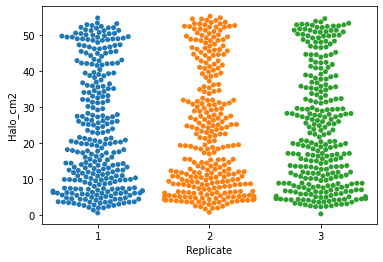

In [84]:
sns.swarmplot(x='Replicate',y='Halo_cm2',data=Nds);

In [96]:
reps = Nd.Replicate.unique()
qtldf = geno.copy().reset_index()

pvalcols = []
pheno = 'Halo_cm2'

for i,r in enumerate(reps):
    
    temp = Nds[(Nds.Replicate==r)].copy()
    temp.index = temp.PMY
    
    newcol = 'Pval%s'%r

    loci = geno[temp.index].drop_duplicates()
    
    loci[newcol] = loci.apply(allelic_manu,
                             args = [temp[pheno].values],axis=1)
    
    pvalcols.append(newcol)
    
    qtldf[newcol] = geno.merge(loci)[newcol]

In [97]:
qtldf.tail()

,Oldindex,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,...,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940,Pval1,Pval2,Pval3
46755,89836,14,915487,GTGCG.ATGCG.GTGTG,snp,915487,14.0,14.0,0.472313,0,...,0,1,1,1,1,1,0,0.522438,0.96801,0.994308
46756,89838,14,918283,A.G,snp,918283,14.0,14.0,0.472313,0,...,0,1,1,1,1,1,0,0.522438,0.96801,0.994308
46757,89840,14,923437,TAGA.CAGA,snp,923437,14.0,14.0,0.472313,0,...,0,1,1,1,1,1,0,0.522438,0.96801,0.994308
46758,89841,14,925335,C.G,snp,925335,14.0,14.0,0.472313,0,...,0,1,1,1,1,1,0,0.522438,0.96801,0.994308
46759,89843,14,926840,A.G,snp,926840,14.0,14.0,0.472313,0,...,0,1,1,1,1,1,0,0.522438,0.96801,0.994308


In [62]:
## Estimate and gather maximum chromosome length
chrommap = geno.groupby('Chrom')['Pos'].max().reset_index()

chrommap['Cumlen'] = [0] + chrommap.Pos.cumsum().tolist()[:-1]
chrommap['Midpts'] = (chrommap.Pos.values/2) + chrommap.Cumlen.values

chrommap.head()

,Chrom,Pos,Cumlen,Midpts
0,1,2264002,0,1132001.0
1,2,1619187,2264002,3073595.5
2,3,1554360,3883189,4660369.0
3,4,1059391,5437549,5967244.5
4,5,1793420,6496940,7393650.0


In [68]:
pvalcols

['Pval1', 'Pval2', 'Pval3']

In [69]:
len(chrommap)

14

In [70]:
chrommap

,Chrom,Pos,Cumlen,Midpts
0,1,2264002,0,1132001.0
1,2,1619187,2264002,3073595.5
2,3,1554360,3883189,4660369.0
3,4,1059391,5437549,5967244.5
4,5,1793420,6496940,7393650.0
5,6,1417305,8290360,8999012.5
6,7,1374738,9707665,10395034.0
7,8,1387111,11082403,11775958.5
8,9,1155758,12469514,13047393.0
9,10,1051064,13625272,14150804.0


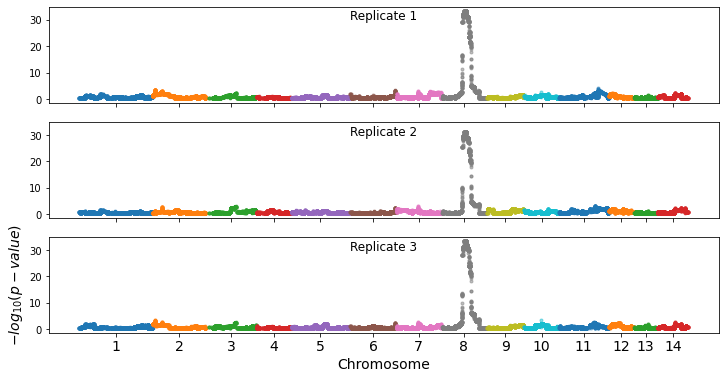

In [100]:
## QTL plots per replicate
fig,ax = plt.subplots(3,1,figsize=(12,6),sharex=True,sharey=True)
fig.set_facecolor('w')
for ri,p in enumerate(pvalcols):
    plt.sca(ax[ri])
    
    plt.title('Replicate %s'%str(ri+1),fontsize=12,y=0.8)

    for i,j in chrommap.iterrows():
    
        temp = qtldf[(qtldf.Chrom == j.Chrom)]

        plt.plot(temp.Pos.values+j.Cumlen, 
                 temp[p].values,'.',alpha=0.5);

plt.xticks(chrommap.Midpts.values, np.arange(1,15),fontsize=14)
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome',fontsize=14);
plt.savefig('../../FIGURES/Amoeba_Halo_QTL_Bt22xFtc555-1_by_replicate.png',
           dpi=100,bbox_inches='tight');

In [138]:
import statsmodels.formula.api as smf

In [148]:
Nds['Rank'] = pd.concat([np.argsort(d[pheno]) for a,d in Nds.groupby('Replicate')])

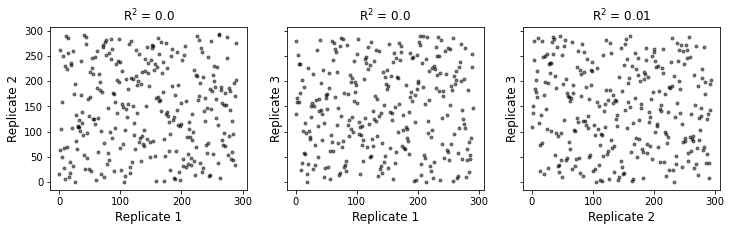

In [149]:
fig,ax = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True)
fig.set_facecolor('w')
pheno = 'Rank'
for i,(r1,r2) in enumerate([(1,2),(1,3),(2,3)]):
    
    temp1 = Nds[(Nds.Replicate==r1)].copy()
    temp1.index = temp1.PMY
    temp2 = Nds[(Nds.Replicate==r2)].copy()
    temp2.index = temp2.PMY
    
    common_segs = set.intersection(set(temp1.dropna().index.values),
                                  set(temp2.dropna().index.values))
    plt.sca(ax[i])
    x = temp1.loc[common_segs,pheno].values
    y = temp2.loc[common_segs,pheno].values
    plt.plot(x,y,'k.',alpha=0.5)
    
    rs = ss.pearsonr(x,y)[0]**2
    
    plt.title('R$^2$ = %s'%np.round(rs,2))
    
    plt.xlabel('Replicate %s'%r1,fontsize=12)
    plt.ylabel('Replicate %s'%r2,fontsize=12)
    
    #test = pd.DataFrame([x,y],index=['x','y']).T
    
    #res = smf.ols('y~x',data=test).fit()
    #print(res.rsquared)
    
plt.savefig('../../FIGURES/Amoeba_Halo_Replicates_Bt22xFtc555-1.png',
           dpi=100,bbox_inches='tight');

In [140]:
len(common_segs)

290

In [130]:

res.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     161.6
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           1.09e-29
Time:                        17:03:42   Log-Likelihood:                -1152.7
No. Observations:                 290   AIC:                             2309.
Df Residuals:                     288   BIC:                             2317.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0049      1.309      7.644      0.000       7.429      12.581
x              0.5811      0.046     12.712      0.000       0.491       0.671
==============================================================================
Omnibus:                       25.687   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.786
Skew:                           0.792   Prob(JB):                     2.07e-07
Kurtosis:                       2.806   Cond. No.                         49.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
?ss.pearsonr

Signature: ss.pearsonr(x, y)
Docstring:
Pearson correlation coefficient and p-value for testing non-correlation.

The Pearson correlation coefficient [1]_ measures the linear relationship
between two datasets.  The calculation of the p-value relies on the
assumption that each dataset is normally distributed.  (See Kowalski [3]_
for a discussion of the effects of non-normality of the input on the
distribution of the correlation coefficient.)  Like other correlation
coefficients, this one varies between -1 and +1 with 0 implying no
correlation. Correlations of -1 or +1 imply an exact linear relationship.
Positive correlations imply that as x increases, so does y. Negative
correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system
producing datasets that have a Pearson correlation at least as extreme
as the one computed from these datasets.

Parameters
----------
x : (N,) array_like
    Input array.
y : (N,) array_like
   

In [55]:
loci.shape

(4668, 295)

In [44]:
temp

,PMY,Replicate,Halo
2,PMY2603,3,1.381
5,PMY2604,3,1.891
8,PMY2605,3,7.883
11,PMY2606,3,0.808
14,PMY2607,3,2.551
...,...,...,...
991,PMY2936,3,6.555
994,PMY2937,3,1.385
997,PMY2938,3,1.210
1000,PMY2939,3,0.919


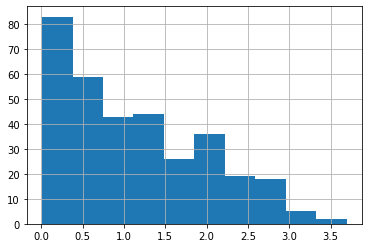

In [37]:
Nd.groupby('PMY').std().Halo.hist();

In [ ]:

PNda = PNd.groupby(["PMY","Z"]).mean().reset_index().groupby("PMY").mean().reset_index()
PNda.drop("Z", axis = 1, inplace = True)

## Gather PMY numbers of paretns

## view head
PNda.head()